# NAML project - Stroke prediction
Cavallini - Eusebio

In [1126]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install imblearn


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\hp\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [1127]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


We start by loading the dataset and visualizing the data 

In [1128]:
dataset = pd.read_csv('healthcare-dataset-stroke-data.csv')
dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [1129]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are clearly some NaN values in the dataset, we will have to deal with them.
Since in the paper it was mentioned that that there were no missing values, we will drop such rows.

We will start by visualizing the data to get a better understanding of the dataset. <br>
In particular, we will look at the distribution of the features and the target variable.

In [1130]:
dataset.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [1131]:
dataset.drop('id', axis=1, inplace=True)
dataset.dropna(inplace=True)

# remove age less than 18
dataset = dataset[dataset['age'] >= 18]

# remove unknown smoking status
dataset = dataset[dataset['smoking_status'] != 'Unknown']

# remove Other gender
dataset = dataset[dataset['gender'] != 'Other']

dataset.drop_duplicates(inplace=True)

In [1132]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3255 entries, 0 to 5108
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             3255 non-null   object 
 1   age                3255 non-null   float64
 2   hypertension       3255 non-null   int64  
 3   heart_disease      3255 non-null   int64  
 4   ever_married       3255 non-null   object 
 5   work_type          3255 non-null   object 
 6   Residence_type     3255 non-null   object 
 7   avg_glucose_level  3255 non-null   float64
 8   bmi                3255 non-null   float64
 9   smoking_status     3255 non-null   object 
 10  stroke             3255 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 305.2+ KB


In [1133]:
#we want to group by age in age groups
dataset['age_group'] = pd.cut(dataset['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+'])


<AxesSubplot:xlabel='age_group', ylabel='count'>

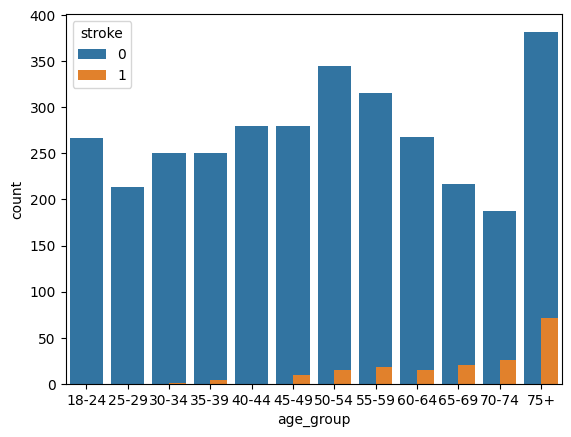

In [1134]:
sns.countplot(x='age_group', data=dataset)
sns.countplot(x='age_group', hue='stroke', data=dataset)

From this plot is difficult to see the real correlation between the features and the target variable. <br>
This is due to the fact that the dataset is unbalanced.

    Age (years): This feature refers to the age of the participants who are over 18 years old.

    Gender: This feature refers to the participant’s gender. The number of men is
    1260, whereas the number of women is 1994.

    Hypertension: This feature refers to whether this participant is hypertensive or
    not. The percentage of participants who have hypertension is 12.54%.

    Heart_disease: This feature refers to whether this participant suffers from heart
    disease or not. The percentage of participants suffering from heart disease is 6.33%.

    Ever married: This feature represents the marital status of the participants, 79.84%
    of whom are married.

    Work type: This feature represents the participant’s work status and has 4 categories
    (private 65.02%, self-employed 19.21%, govt_job 15.67% and never_worked 0.1%).

    Residence type: This feature represents the participant’s living status and has
    2 categories (urban 51.14%, rural 48.86%).

    Avg glucose level (mg/dL): This feature captures the participant’s average glucose level.

    BMI (Kg/m2): This feature captures the body mass index of the participants.
    
    Smoking Status: This feature captures the participant’s smoking status and has
    3 categories (smoke 22.37%, never smoked 52.64% and formerly smoked 24.99%).
    
    Stroke: This feature represents if the participant previously had a stroke or not.
    The percentage of participants who have suffered a stroke is 5.53%

In [1135]:
dataset.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000,3255.000000
mean,50.445776,0.125346,0.063287,108.804138,30.535730,0.055300
std,17.573956,0.331161,0.243516,48.330631,7.222929,0.228599
min,18.000000,0.000000,0.000000,55.120000,11.500000,0.000000
25%,36.000000,0.000000,0.000000,77.210000,25.500000,0.000000
50%,51.000000,0.000000,0.000000,92.670000,29.300000,0.000000
75%,64.000000,0.000000,0.000000,116.220000,34.300000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


<AxesSubplot:>

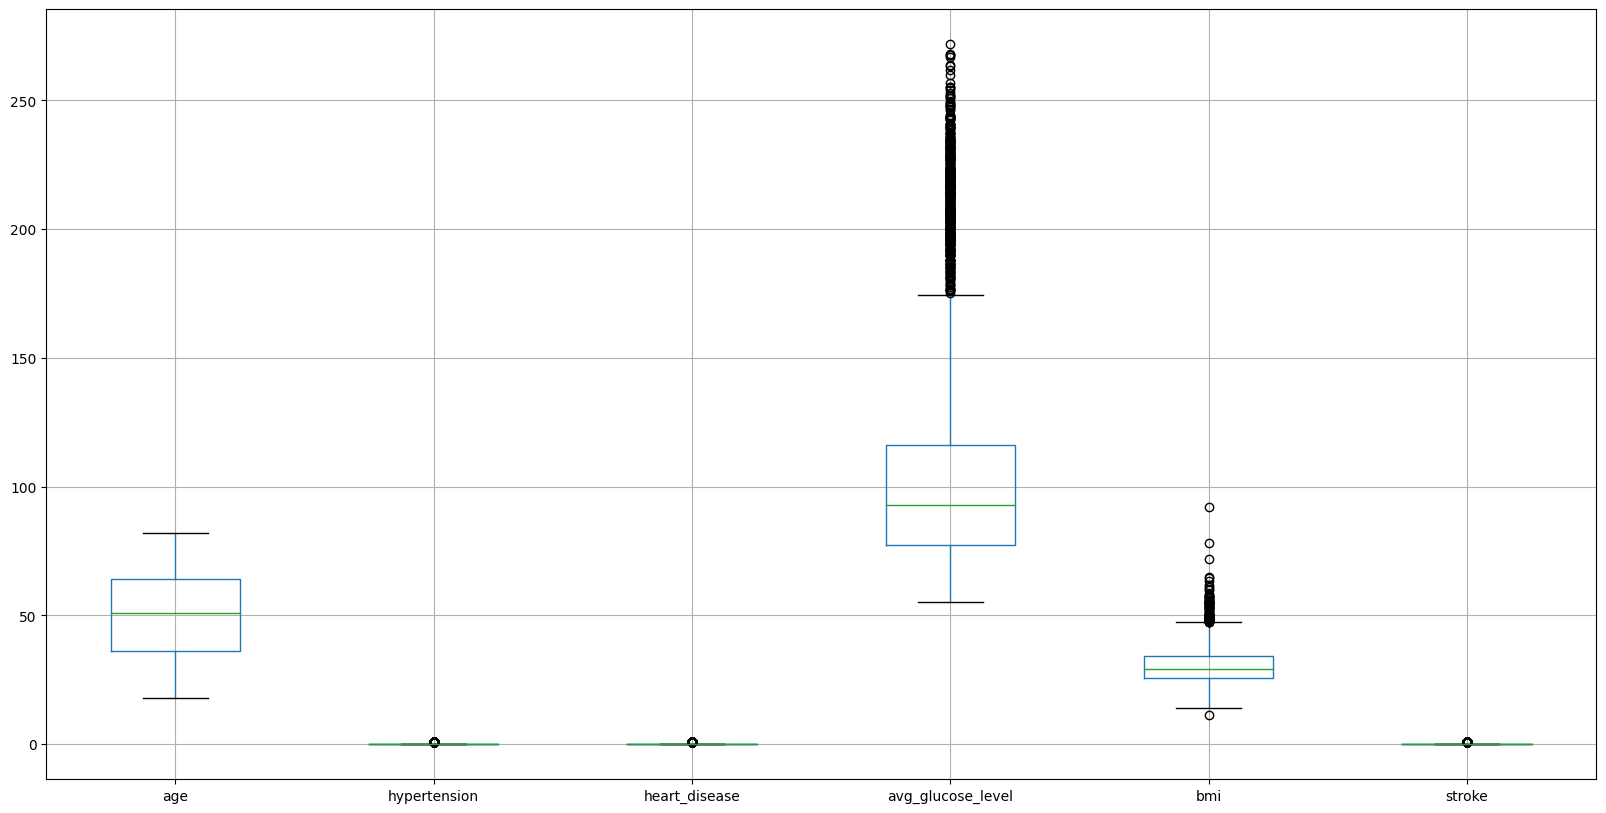

In [1136]:
# plot the values to find the outliers
plt.figure(figsize=(20, 10))
dataset.boxplot()

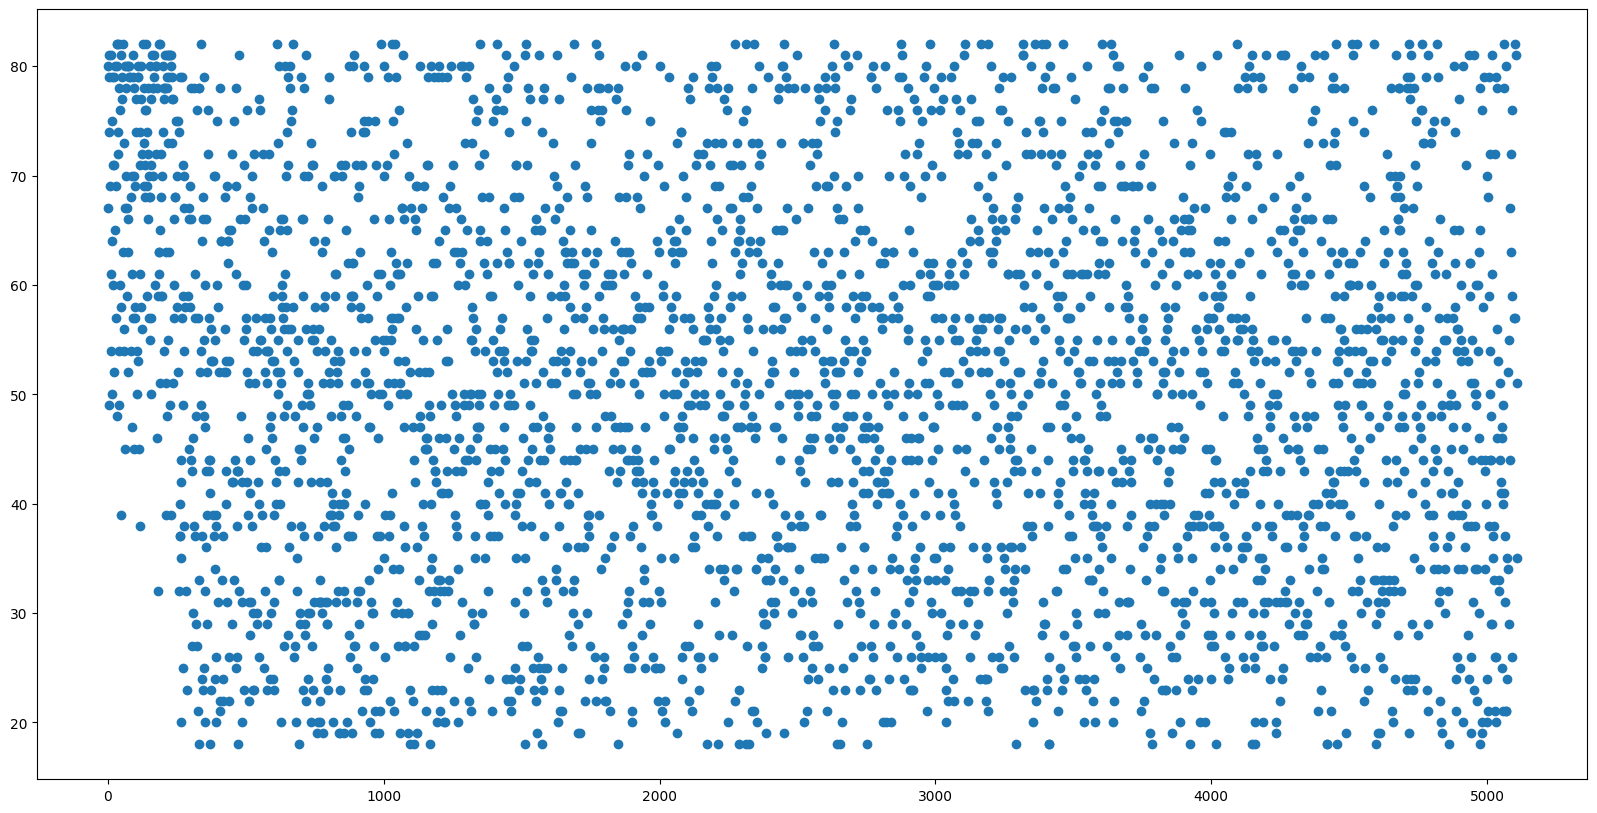

In [1137]:
plt.figure(figsize=(20, 10))
plt.plot(dataset['age'], 'o')

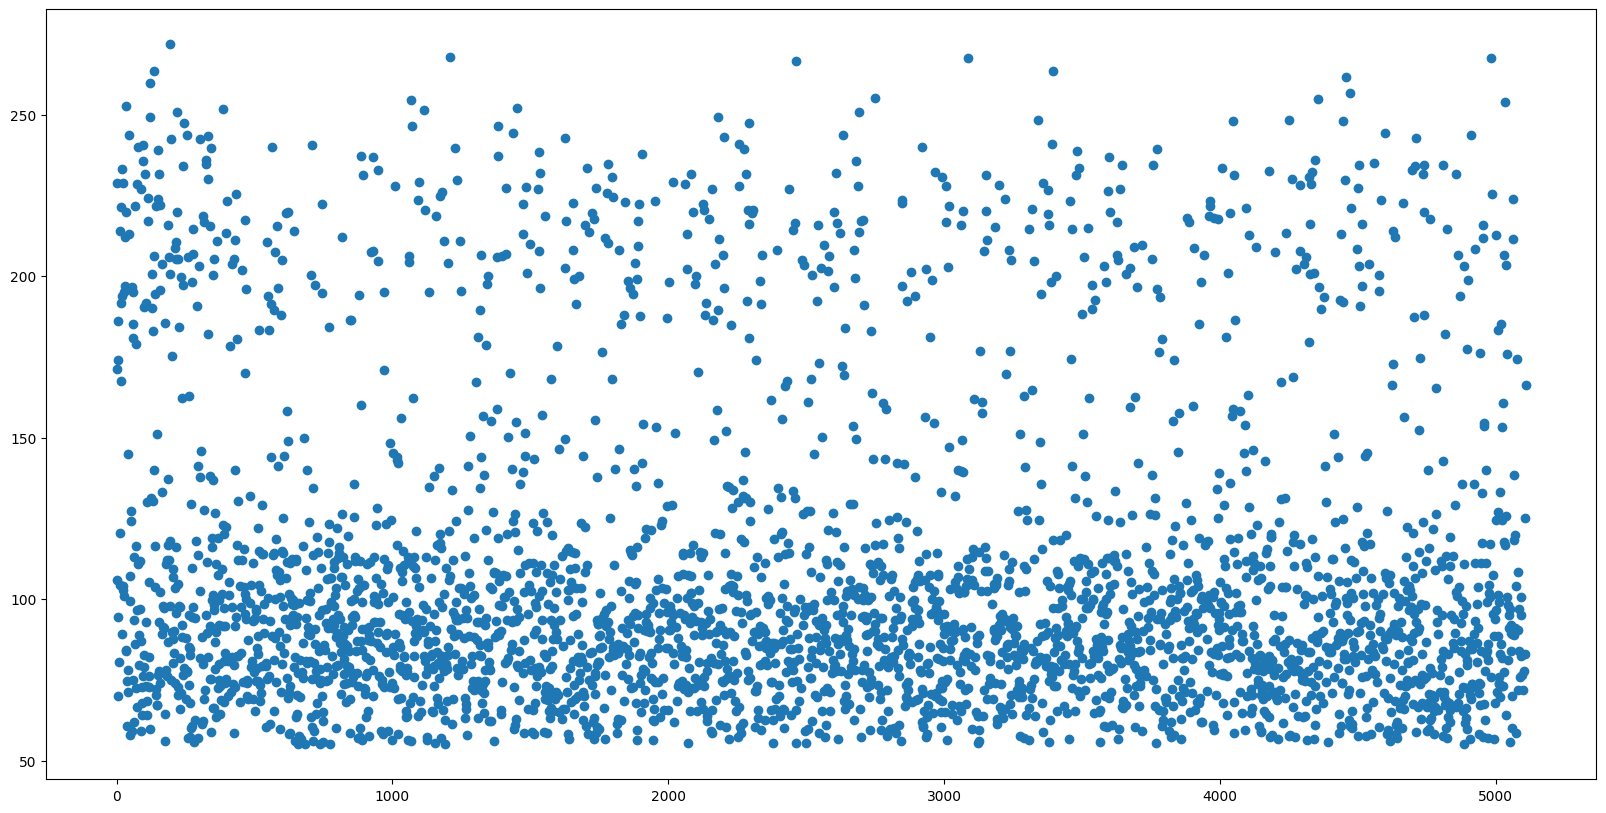

In [1138]:
plt.figure(figsize=(20, 10))
plt.plot(dataset['avg_glucose_level'], 'o')

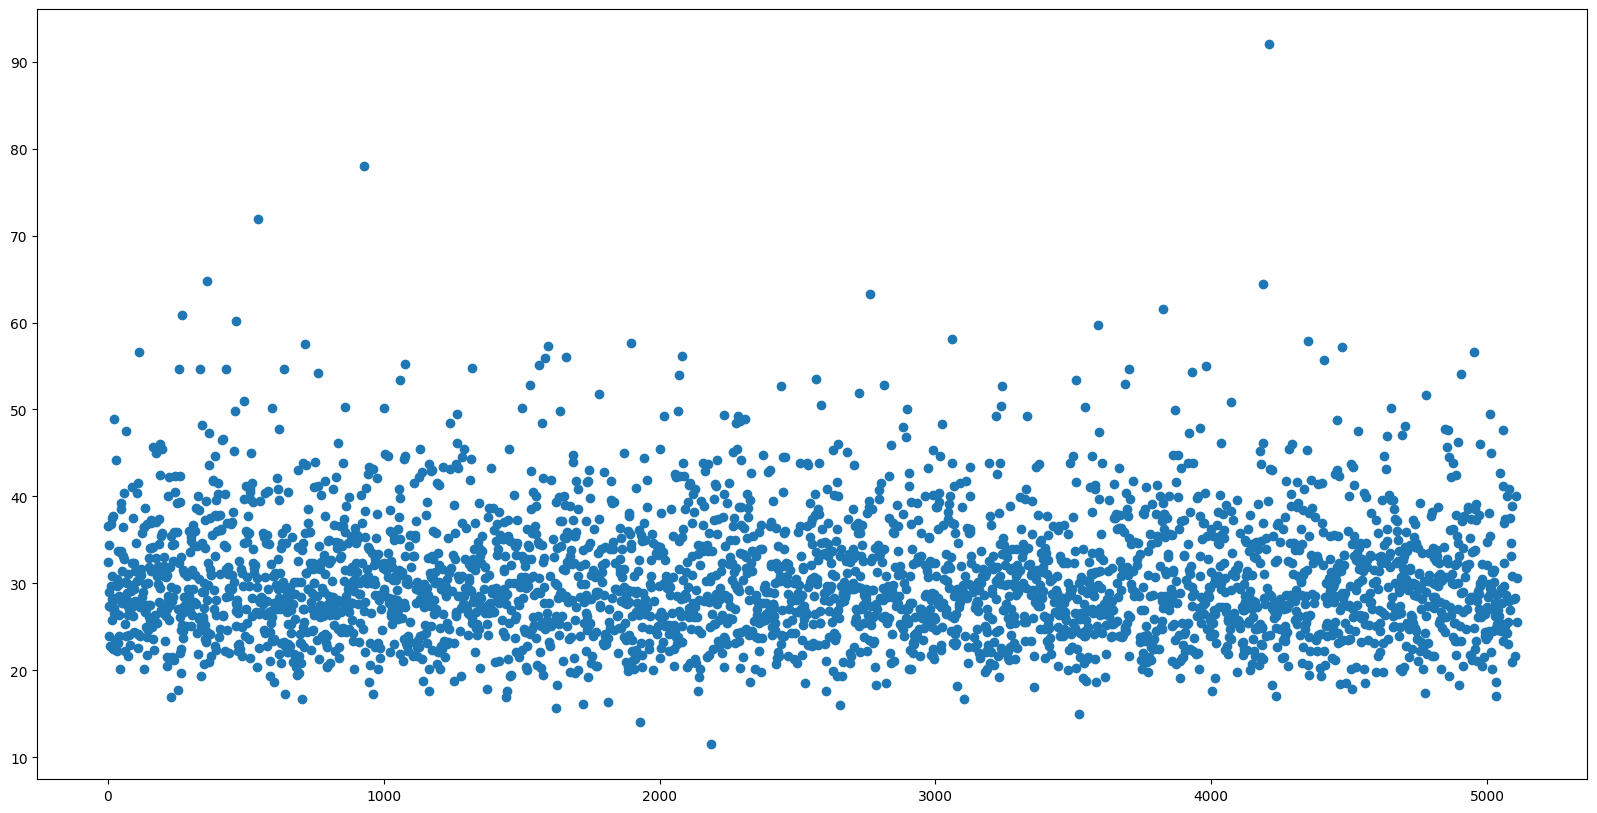

In [1139]:
plt.figure(figsize=(20, 10))
plt.plot(dataset['bmi'], 'o')

The BMI plot presents a clear outlier for a BMI of 92.0. We will remove this outlier from the dataset.

In [1140]:
dataset = dataset[dataset['bmi'] < 92]

We can see that the minimum age in the cleaned dataset is 18, as required in the paper. <br>

In [1141]:
# counting gender
gender_count = dataset['gender'].value_counts()
print(gender_count)

# counting hypertension
hypertension_count =dataset['hypertension'].value_counts()
print(hypertension_count)
print("Hypertension fraction: ", hypertension_count[1]/(hypertension_count[0]+hypertension_count[1]))

# counting heart disease
heart_disease_count =dataset['heart_disease'].value_counts()
print(heart_disease_count)
print("Hearth disease fraction: " ,heart_disease_count[1]/(heart_disease_count[0]+heart_disease_count[1]))

# counting ever married
ever_married_count =dataset['ever_married'].value_counts()
print(ever_married_count)
print("Married fraction ", ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))

# counting work type
work_type_count =dataset['work_type'].value_counts()
print(work_type_count)
print("Private fraction ", work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Self Employed fraction ",work_type_count[1]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Gov fraction ",work_type_count[2]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
print("Never Worked fraction ",work_type_count[3]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))

# counting residence type
residence_type_count =dataset['Residence_type'].value_counts()
print(residence_type_count)
print("Urban fraction ", residence_type_count[0]/(residence_type_count[0]+residence_type_count[1]))
print("Rural fraction ", residence_type_count[1]/(residence_type_count[0]+residence_type_count[1]))

# counting smoking status
smoking_status_count =dataset['smoking_status'].value_counts()
print(smoking_status_count)
print("Never Smoked fraction ", smoking_status_count[0]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))
print("Formely Smoked fraction ", smoking_status_count[1]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))
print("Smokes fraction ", smoking_status_count[2]/(smoking_status_count[0]+smoking_status_count[1]+smoking_status_count[2]))


# counting stroke
stroke_count =dataset['stroke'].value_counts()
print(stroke_count)
print("Stroke fraction ", stroke_count[1]/(stroke_count[0]+stroke_count[1]))

gender
Female    1994
Male      1260
Name: count, dtype: int64
hypertension
0    2847
1     407
Name: count, dtype: int64
Hypertension fraction:  0.12507682851874616
heart_disease
0    3048
1     206
Name: count, dtype: int64
Hearth disease fraction:  0.06330669944683466
ever_married
Yes    2598
No      656
Name: count, dtype: int64
Married fraction  0.7984019668100799
work_type
Private          2116
Self-employed     625
Govt_job          510
Never_worked        3
Name: count, dtype: int64
Private fraction  0.6502765826674862
Self Employed fraction  0.19207129686539642
Gov fraction  0.15673017824216348
Never Worked fraction  0.0009219422249539029
Residence_type
Urban    1664
Rural    1590
Name: count, dtype: int64
Urban fraction  0.5113706207744315
Rural fraction  0.48862937922556854
smoking_status
never smoked       1713
formerly smoked     813
smokes              728
Name: count, dtype: int64
Never Smoked fraction  0.5264290104486785
Formely Smoked fraction  0.24984634296250768
Smok

C:\Users\hp\AppData\Local\Temp\ipykernel_3540\3057340175.py:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Married fraction ", ever_married_count[0]/(ever_married_count[0]+ever_married_count[1]))
C:\Users\hp\AppData\Local\Temp\ipykernel_3540\3057340175.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("Private fraction ", work_type_count[0]/(work_type_count[0]+work_type_count[1]+work_type_count[2]+work_type_count[3]))
C:\Users\hp\AppData\Local\Temp\ipykernel_3540\3057340175.py:24: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will alwa

In [1142]:
males_who_had_stroke = dataset[(dataset['gender'] == 'Male') & (dataset['stroke'] == 1)]
females_who_had_stroke = dataset[(dataset['gender'] == 'Female') & (dataset['stroke'] == 1)]
print("Percent of males who had a stroke: ", males_who_had_stroke.shape[0]/stroke_count[1])
print("Number of females who had a stroke: ", females_who_had_stroke.shape[0]/stroke_count[1])

Percent of males who had a stroke:  0.4166666666666667
Number of females who had a stroke:  0.5833333333333334


## Data preprocessing

<AxesSubplot:xlabel='stroke', ylabel='percent'>

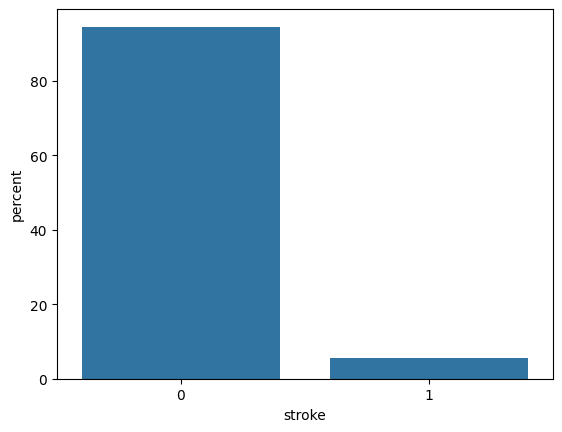

In [1143]:
sns.countplot(x='stroke', data=dataset, stat='percent')

It is evident that the dataset is strongly unbalanced towards the non-stroke cathegory. <br>
In fact the percentage of patients who had a stroke in the dataset is $ \lt $ 5.6%.

Since this is non ideal for the training of a model, we will have to balance the dataset before training the model. <br>
The method proposed in the paper is to use the Synthetic Minority Over-sampling Technique (SMOTE) to balance the dataset.

However we first need to preprocess the data, by encoding the categorical variables and normalizing the numerical variables.

In [1228]:
features = np.array(dataset.columns[:-2])
print(features)

X = dataset.iloc[:, :-2].values
y = dataset.iloc[:, -2].values

print(X)
print(y)

['gender' 'age' 'hypertension' 'heart_disease' 'ever_married' 'work_type'
 'Residence_type' 'avg_glucose_level' 'bmi' 'smoking_status']
[['Male' 67.0 0 ... 228.69 36.6 'formerly smoked']
 ['Male' 80.0 0 ... 105.92 32.5 'never smoked']
 ['Female' 49.0 0 ... 171.23 34.4 'smokes']
 ...
 ['Female' 81.0 0 ... 125.2 40.0 'never smoked']
 ['Female' 35.0 0 ... 82.99 30.6 'never smoked']
 ['Male' 51.0 0 ... 166.29 25.6 'formerly smoked']]
[1 1 1 ... 0 0 0]


Since the dataset uses a mix of numerical and categorical variables, we will use a variation of SMOTE called SMOTENC, which is able to handle both types of variables.

In [1229]:
# We should normalize the data before augmenting the dataset

X_tmp = np.array(X[:, [1, 7, 8]])
X_tmp_mean = X_tmp.mean()
X_tmp_std = X_tmp.std()
X_tmp = (X_tmp - X_tmp_mean) / X_tmp_std
X[:, [1, 7, 8]] = X_tmp

print(X)

[['Male' 0.0835331545191152 0 ... 3.6969934656478376 -0.5958483375849923
  'formerly smoked']
 ['Male' 0.3740581346952139 0 ... 0.9533202490155582 -0.6874754467174543
  'never smoked']
 ['Female' -0.3187322026477906 0 ... 2.412873053269481
  -0.6450141034609476 'smokes']
 ...
 ['Female' 0.3964062100933753 0 ... 1.3841911426921107
  -0.5198648812312435 'never smoked']
 ['Female' -0.6316052582220507 0 ... 0.4408788801357164
  -0.7299367899739609 'never smoked']
 ['Male' -0.27403605185146773 0 ... 2.302473560802564 -0.8416771669647681
  'formerly smoked']]


In [1230]:
# Balance the dataset using SMOTE
from imblearn.over_sampling import SMOTENC, SMOTE

smote = SMOTENC(categorical_features=[0, 2, 3, 4, 5, 6, 9], sampling_strategy='minority', k_neighbors=100)



print(X.shape)
print(y.shape)

X, y = smote.fit_resample(X, y)

print(X.shape)
print(y.shape)


(3254, 10)
(3254,)


ValueError: Expected n_neighbors <= n_samples_fit, but n_neighbors = 1001, n_samples_fit = 180, n_samples = 180

In [ ]:
X_tmp = X[:, [1, 7, 8]]
X_tmp = X_tmp * X_tmp_std + X_tmp_mean
X[:, [1, 7, 8]] = X_tmp

print(X)

[['Male' 67.0 0 ... 228.69 36.60000000000001 'formerly smoked']
 ['Male' 80.0 0 ... 105.92 32.5 'never smoked']
 ['Female' 49.0 0 ... 171.22999999999996 34.4 'smokes']
 ...
 ['Male' 51.718945654303134 1 ... 86.66079571545373 36.734975269769606
  'formerly smoked']
 ['Female' 73.13025361801482 1 ... 190.49767643506868 36.73966665714728
  'never smoked']
 ['Female' 54.490769855713914 0 ... 103.93089157025759 27.226384521642913
  'smokes']]


      gender        age hypertension heart_disease ever_married  \
0       Male       67.0            0             1          Yes   
1       Male       80.0            0             1          Yes   
2     Female       49.0            0             0          Yes   
3     Female       79.0            1             0          Yes   
4       Male       81.0            0             0          Yes   
...      ...        ...          ...           ...          ...   
6143    Male  81.225571            0             1          Yes   
6144    Male  73.103532            1             0          Yes   
6145    Male  51.718946            1             0          Yes   
6146  Female  73.130254            1             0          Yes   
6147  Female   54.49077            0             0          Yes   

          work_type Residence_type avg_glucose_level        bmi  \
0           Private          Urban            228.69       36.6   
1           Private          Rural            105.92       32

<AxesSubplot:xlabel='stroke', ylabel='percent'>

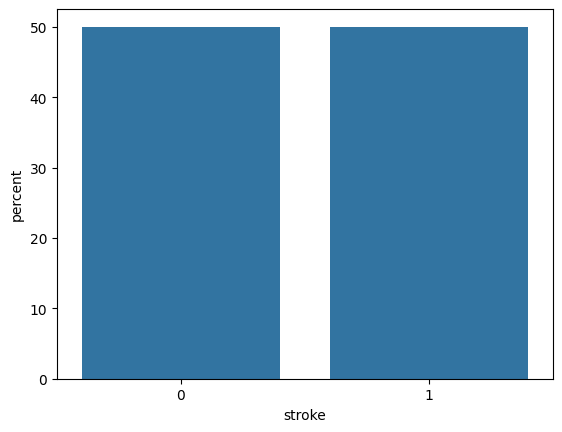

In [ ]:
block = np.block([[X, y[:, None]]])
dataset_balanced = pd.DataFrame(block, columns=features.tolist() + ['stroke'])

print(dataset_balanced)

sns.countplot(x='stroke', data=dataset_balanced, stat='percent')

As we can see, the dataset is now balanced, and we can proceed with the training of the model.

<AxesSubplot:xlabel='gender', ylabel='count'>

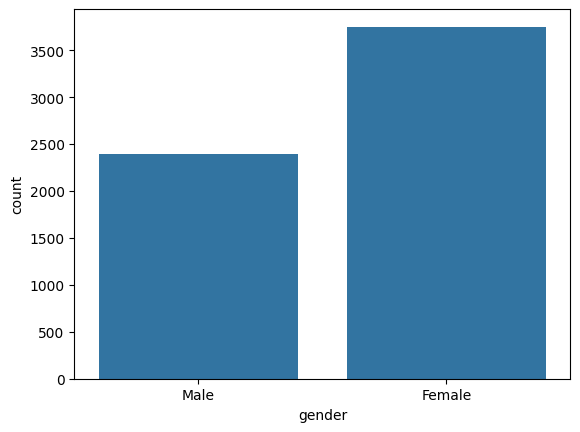

In [ ]:
sns.countplot(x='gender', data=dataset_balanced)

## Data visualization

In [ ]:
#we want to group by age in age groups
dataset_balanced['age_group'] = pd.cut(dataset_balanced['age'], bins=[17, 24, 29, 34, 39, 44, 49, 54, 59, 64, 69, 74, 100], labels=['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75+'])

Now we can visualize the data to get a better understanding of the dataset. <br>
In particular, the trend of stroke is clearly correlated to age and more visible in the data.

<AxesSubplot:xlabel='age_group', ylabel='percent'>

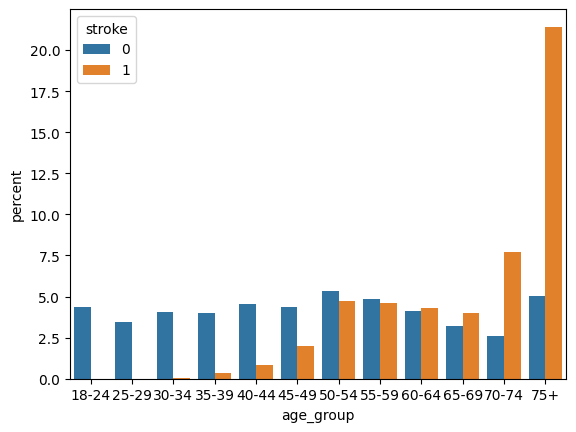

In [ ]:
sns.countplot(x='age_group', hue='stroke', data=dataset_balanced, stat='percent')

Another way to visualize the same data is to color the percentage of stroke in the dataset per age-group. <br>

<AxesSubplot:xlabel='gender', ylabel='percent'>

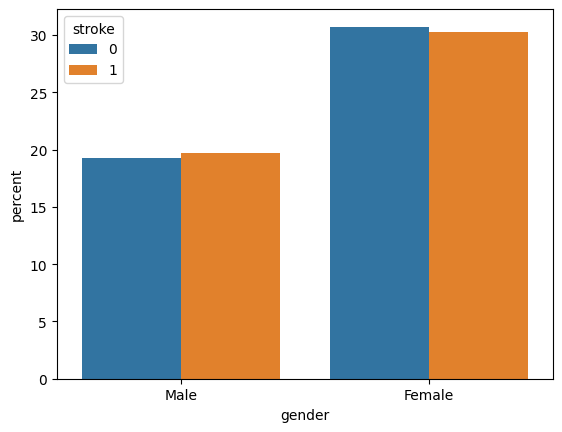

In [ ]:
sns.countplot(x='gender', hue='stroke', data=dataset_balanced, stat='percent')

In [ ]:
stroke_count =dataset_balanced['stroke'].value_counts()
males_who_had_stroke = dataset_balanced[(dataset_balanced['gender'] == 'Male') & (dataset_balanced['stroke'] == 1)]
females_who_had_stroke = dataset_balanced[(dataset_balanced['gender'] == 'Female') & (dataset_balanced['stroke'] == 1)]
print("Percent of males who had a stroke: ", males_who_had_stroke.shape[0]/stroke_count[1])
print("Number of females who had a stroke: ", females_who_had_stroke.shape[0]/stroke_count[1])

Percent of males who had a stroke:  0.39459986987638257
Number of females who had a stroke:  0.6054001301236175


<AxesSubplot:xlabel='hypertension', ylabel='percent'>

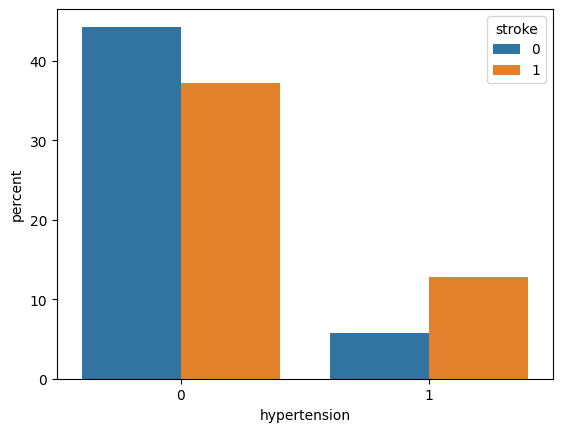

In [ ]:
sns.countplot(x='hypertension', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='heart_disease', ylabel='percent'>

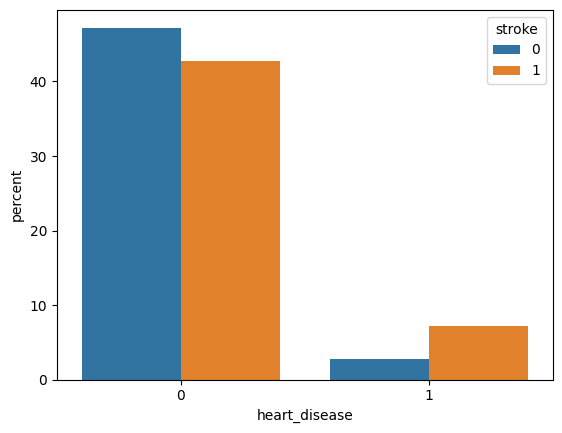

In [ ]:
sns.countplot(x='heart_disease', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='ever_married', ylabel='percent'>

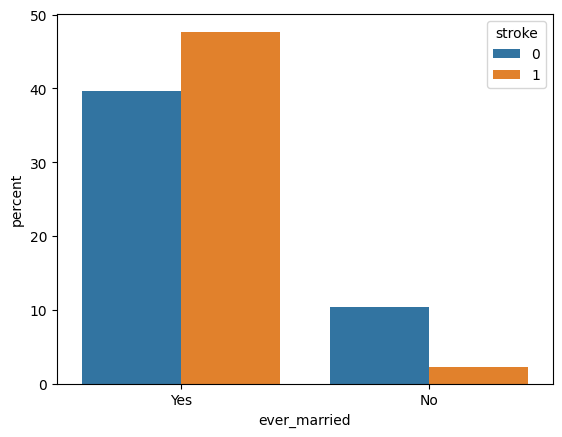

In [ ]:
sns.countplot(x='ever_married', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='work_type', ylabel='percent'>

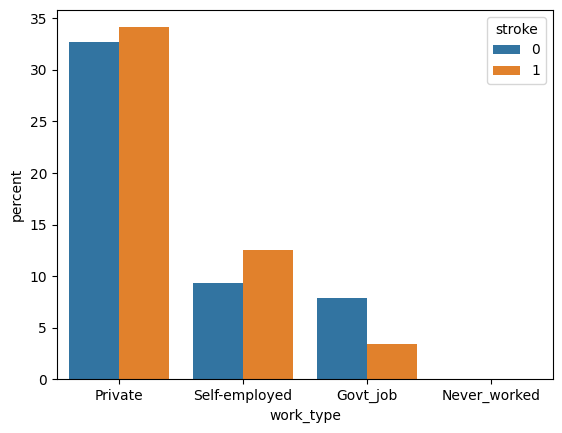

In [ ]:
sns.countplot(x='work_type', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='Residence_type', ylabel='percent'>

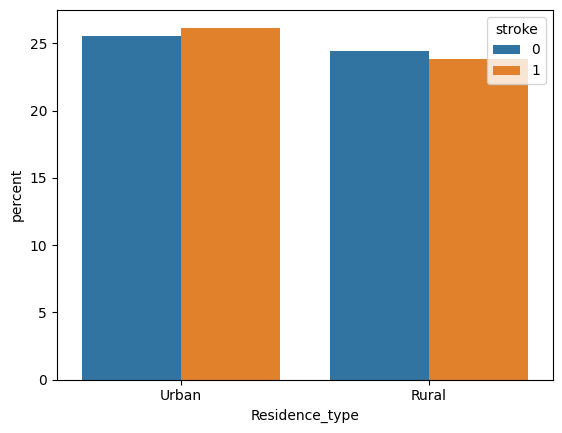

In [ ]:
sns.countplot(x='Residence_type', hue='stroke', data=dataset_balanced, stat='percent')

<AxesSubplot:xlabel='smoking_status', ylabel='percent'>

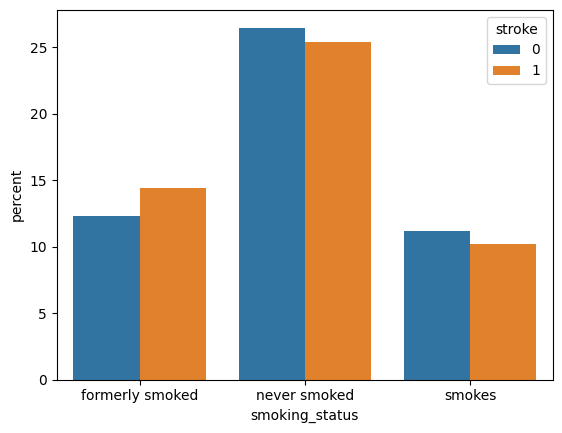

In [ ]:
sns.countplot(x='smoking_status', hue='stroke', data=dataset_balanced, stat='percent')

In [ ]:
dataset_balanced['BMI CATEGORY'] = pd.cut(dataset_balanced['bmi'], bins=[0, 18.5, 25.0, 30.0, 35.0, 40.0, 100], labels=['Underweight', 'Healthy', 'Overweight', 'Obese I', 'Obese II', 'Obese III'])

<AxesSubplot:xlabel='BMI CATEGORY', ylabel='percent'>

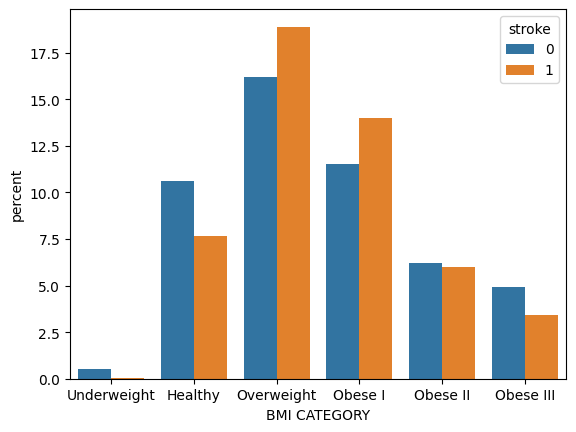

In [ ]:
sns.countplot(x='BMI CATEGORY', hue='stroke', data=dataset_balanced, stat='percent')

## Dividing the dataset in training and testing set

We will divide the dataset in training and testing set, using a 80-20 split, and train the model on the training set.

In [ ]:
from sklearn.preprocessing import LabelEncoder

labels = dataset_balanced.columns[:-3]

X = dataset_balanced.iloc[:, :-3].values
y = dataset_balanced.iloc[:, -3].values # stroke

print(labels)

labelencoder = LabelEncoder()

X[:, 0] = labelencoder.fit_transform(X[:, 0]) # gender
X[:, 4] = labelencoder.fit_transform(X[:, 2]) # ever_married
X[:, 5] = labelencoder.fit_transform(X[:, 3]) # work_type
X[:, 6] = labelencoder.fit_transform(X[:, 4]) # Residence_type
X[:, 9] = labelencoder.fit_transform(X[:, 5]) # smoking_status

y = labelencoder.fit_transform(y)

X = np.array(X)
y = np.array(y)


Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
print(X_train)
print(y_train)

print(X_train.shape)
print(y_train.shape)

[[0 68.0932123151389 1 ... 181.12786661880511 29.630497241194462 0]
 [1 67.01886392351825 0 ... 193.79565748062723 31.945290380726426 1]
 [0 60.0 1 ... 96.0 44.5 0]
 ...
 [0 33.0 0 ... 131.28 25.1 0]
 [0 67.83831858289278 0 ... 93.72267856372841 24.736135695178703 0]
 [0 54.196009191438385 0 ... 109.92279356599313 40.71936630762718 0]]
[1 1 0 ... 0 1 1]
(4918, 10)
(4918,)


## Feature selection and ranking

In the paper, the authors used used a Random Forest Classifier and an information gain method to rank the features. <br>

### Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# use a Random Forest Classifier to determine the importance of each feature by assigning a rank to each feature
# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier()

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)


RandomForestClassifier()

In [ ]:
ranks = rf_classifier.feature_importances_
for i,f in enumerate(labels):
    print(f, ranks[i])

print(f"Sum (ideally 1): {np.sum(ranks)}")

gender 0.019664993920955796
age 0.4458872950095044
hypertension 0.009650618785212742
heart_disease 0.004556028871746303
ever_married 0.0065193113144776955
work_type 0.00494606670352153
Residence_type 0.01107132032375532
avg_glucose_level 0.2830744594484931
bmi 0.20833466348750757
smoking_status 0.006295242134825564
Sum (ideally 1): 1.0
